**420-A58-SF - Algorithmes d'apprentissage non supervisé - Hiver 2023 - Spécialisation technique en Intelligence Artificielle**<br/>
MIT License - Copyright (c) 2023 Mikaël Swawola
<br/>
![Travaux Pratiques - Regroupement hiérachique](static/01-03-banner.png)
<br/>
**Objectif:** cette séance de travaux pratiques a pour objectif l'analyse de données génomiques (jeu de données NCI60). Les techniques mise en oeuvre seront l'ACP et le regroupement hiérarchique

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

# Le reste des modules sera importé au fur et à mesure des exercices ...

In [4]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
# Configuration de la visualisation
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams['figure.figsize']=(12,8)

## 1 - Lecture des données

Les méthodes d'apprentissage non supervisé comme l'ACP et le clustering sont très populaires en analyse des données génomiques. Ces méthodes seront illustrées sur le jeu de données de biopuces NCI60, qui
consiste en 6830 **mesures d'expression de gènes** sur 64 lignées de cellules cancéreuses.

**Exercice 1-1 - À l'aide de la librairie Pandas, lire le fichier de données `NCI60.csv`**

In [5]:
import pandas as pd
# Compléter cette cellule ~ 1 ligne de code
df = pd.read_csv('../../data/NCI60.csv')

**Exercice 1-2 - Combien d'observations et de variables compte le jeu de données ? Que constatez vous ?**

In [6]:
# Compléter cette cellule ~ 1 ligne de code
df.shape

## fat data = len(columns) > len(rows)

(64, 6831)

In [7]:
df.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
0,V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.450000,...,-0.990020,0.000000,0.030000,-0.175000,0.629981,-0.030000,0.000000,0.280000,-0.340000,-1.930000
1,V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.040039,...,-0.270058,-0.300039,-0.250039,-0.535039,0.109941,-0.860039,-1.250049,-0.770039,-0.390039,-2.000039
2,V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.430000,...,0.319981,0.120000,-0.740000,-0.595000,-0.270020,-0.150000,0.000000,-0.120000,-0.410000,0.000000
3,V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.020000,...,-1.240020,-0.110000,-0.160000,0.095000,-0.350019,-0.300000,-1.150010,1.090000,-0.260000,-1.100000
4,V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.235000,...,0.554980,-0.775000,-0.515000,-0.320000,0.634980,0.605000,0.000000,0.745000,0.425000,0.145000


**Exercice 1-3 - Une chance, ce jeu de données est fourni avec le type de cancer pour chaque cellule cancéreuse. Lire le fichier `NCI60-labels.csv`**

In [8]:
# Compléter cette cellule ~ 1 ligne de code
df2 = pd.read_csv('../../data/NCI60-labels.csv')
df2.describe()

,Unnamed: 0
count,64.000000
mean,32.500000
std,18.618987
min,1.000000
25%,16.750000
50%,32.500000
75%,48.250000
max,64.000000


**Exercice 1-4 - Selon vous, est-il nécéssaire de mettre à l'échelle (standardiser ou normaliser) le jeu de données ? Justifier votre réponse.**

In [9]:
df.select_dtypes(include='object')

,Unnamed: 0
0,V1
1,V2
2,V3
3,V4
4,V5
...,...
59,V60
60,V61
61,V62
62,V63


In [10]:
# Votre réponse ici
## Oui, l'échelle est très grande (1 à 64000)
#### Pourtant, il faut PAS standardiser. On souhaite garder l'expression de gènes.
#### Pour les données génétique on ne standardise pas
from sklearn.preprocessing import StandardScaler

def get_numeric_df(pDf):
    return pd.DataFrame(pDf.select_dtypes(exclude='object'))


In [11]:
## not used for this example with genetic data
def get_scaled_df(pDf):
    scaler = StandardScaler()
    return pd.DataFrame( scaler.fit_transform(pDf))


In [12]:
numericDf = get_numeric_df(df)
scaledDf = get_scaled_df(numericDf)
scaledDf.describe()

,0,1,2,3,4,5,6,7,8,9,...,6820,6821,6822,6823,6824,6825,6826,6827,6828,6829
count,6.400000e+01,6.400000e+01,64.000000,6.400000e+01,6.400000e+01,64.000000,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,...,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,6.400000e+01,64.000000,6.400000e+01,6.400000e+01,6.400000e+01
mean,2.775558e-17,-1.387779e-17,0.000000,3.122502e-17,-1.040834e-17,0.000000,2.775558e-17,2.775558e-17,1.734723e-17,-2.775558e-17,...,-2.428613e-17,2.775558e-17,-1.387779e-17,5.204170e-17,6.938894e-18,5.551115e-17,0.000000,2.775558e-17,-6.938894e-18,6.938894e-18
std,1.007905e+00,1.007905e+00,1.007905,1.007905e+00,1.007905e+00,1.007905,1.007905e+00,1.007905e+00,1.007905e+00,1.007905e+00,...,1.007905e+00,1.007905e+00,1.007905e+00,1.007905e+00,1.007905e+00,1.007905e+00,1.007905,1.007905e+00,1.007905e+00,1.007905e+00
min,-2.377270e+00,-2.877193e+00,-3.931262,-2.105826e+00,-1.768435e+00,-2.032645,-2.555051e+00,-2.029547e+00,-2.115392e+00,-2.630141e+00,...,-2.004194e+00,-1.048700e+00,-1.298802e+00,-2.569869e+00,-2.344267e+00,-1.617887e+00,-1.767830,-2.014441e+00,-1.850851e+00,-1.985687e+00
25%,-8.071713e-01,-5.018980e-01,-0.401395,-9.173725e-01,-5.217310e-01,-0.468724,-7.230938e-01,-5.412910e-01,-8.472563e-01,-7.803041e-01,...,-6.570984e-01,-5.165919e-01,-5.595580e-01,-5.668481e-01,-5.245635e-01,-5.274250e-01,-0.577904,-7.115609e-01,-7.206783e-01,-8.304080e-01
50%,4.353664e-02,3.701052e-02,0.046342,3.033881e-01,-5.421676e-02,-0.019322,-5.352873e-02,6.883255e-02,-1.832542e-03,-3.022115e-02,...,9.005226e-02,-3.585180e-01,-2.652086e-01,-1.940283e-01,-1.590203e-01,-1.675724e-01,-0.075668,1.623610e-01,-2.312333e-01,-9.583766e-02
75%,7.515195e-01,5.060775e-01,0.424308,9.426144e-01,3.821298e-01,0.512757,6.194484e-01,5.451041e-01,6.909453e-01,7.042364e-01,...,4.352942e-01,1.401940e-01,1.145247e-01,2.907792e-01,3.165084e-01,1.868279e-01,0.036861,5.497099e-01,5.719101e-01,7.389014e-01
max,2.190290e+00,3.017748e+00,2.721339,1.687994e+00,3.509280e+00,3.317043,2.502375e+00,2.226625e+00,2.323083e+00,2.310550e+00,...,3.406828e+00,4.272379e+00,4.687052e+00,4.336512e+00,4.400030e+00,4.848555e+00,4.375607,3.440368e+00,3.381761e+00,2.535260e+00


## 2 - Analyse en composantes principales (ACP)

**Exercice 2-1 - À l'aide de la libraire Scikit-learn, effectuer une analyse en composantes principales. Vérifier la proportion de variance (PVE) et afficher sur un graphique les deux premières composantes et le type de cancer. Que constatez-vous ?**

In [13]:
import numpy as np
from sklearn.decomposition import PCA

In [14]:
# Compléter cette cellule (ACP) ~ 3 lignes de code
#pca = PCA(n_components=2)
pca = PCA()
pca.fit(numericDf)

PCA()

In [15]:
# Compléter cette cellule (variance) ~ 1 ligne de code
pca.explained_variance_ratio_

array([1.48929380e-01, 8.30069900e-02, 6.58356299e-02, 4.30602805e-02,
       3.84679156e-02, 3.50668738e-02, 2.87616238e-02, 2.81743382e-02,
       2.63836759e-02, 2.15699493e-02, 2.10004796e-02, 2.00221747e-02,
       1.83045185e-02, 1.76738057e-02, 1.67214706e-02, 1.61035083e-02,
       1.57771736e-02, 1.45403380e-02, 1.44771299e-02, 1.41174149e-02,
       1.37342449e-02, 1.29302547e-02, 1.26046525e-02, 1.18399066e-02,
       1.17950730e-02, 1.10937289e-02, 1.06165363e-02, 1.03040835e-02,
       1.01613180e-02, 9.94134819e-03, 9.58581713e-03, 9.38499008e-03,
       8.75949244e-03, 8.66585060e-03, 8.36666882e-03, 8.27960985e-03,
       8.11199187e-03, 7.99036568e-03, 7.58591497e-03, 7.46207325e-03,
       7.29879522e-03, 7.14742150e-03, 7.00002418e-03, 6.80611231e-03,
       6.66015321e-03, 6.29690764e-03, 6.22513355e-03, 5.92205774e-03,
       5.47403461e-03, 5.37111591e-03, 5.17708667e-03, 4.89858397e-03,
       4.74239353e-03, 4.57705635e-03, 4.29647247e-03, 4.17565640e-03,
      

<BarContainer object of 64 artists>

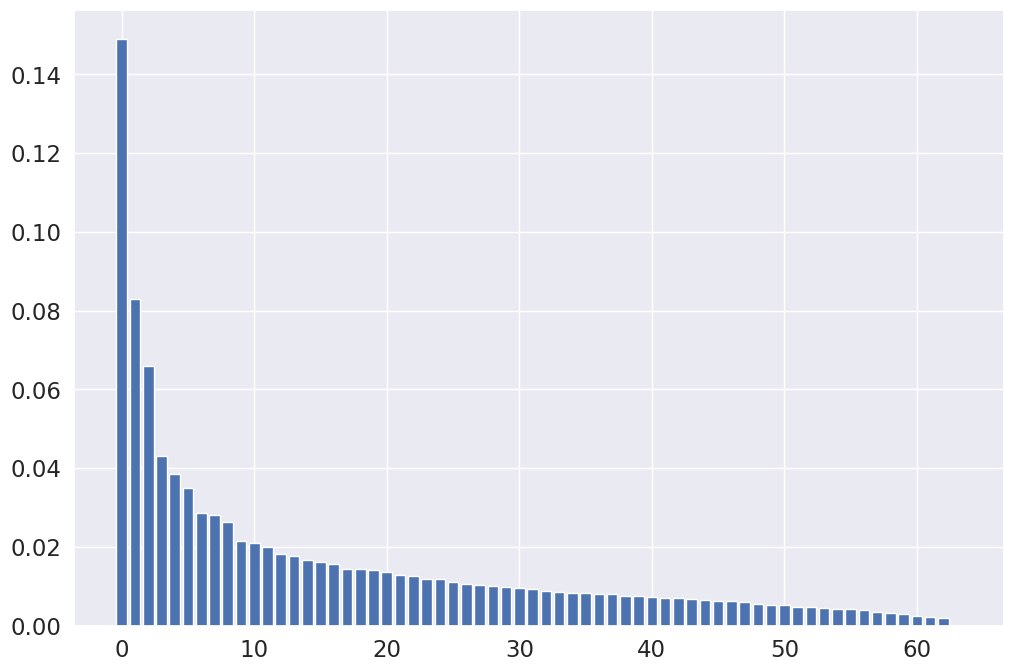

In [16]:
# Compléter cette cellule (affichage) ~ 1 ligne de code
plt.bar(range(0, pca.n_components_), pca.explained_variance_ratio_)

In [17]:
## barchar (variance/composante)
## scatterplot: pc1 et pc2
## afficher le diagramme en nuage de points avec coloration des differentes overvations
## mettre capture d'écran dans le forum

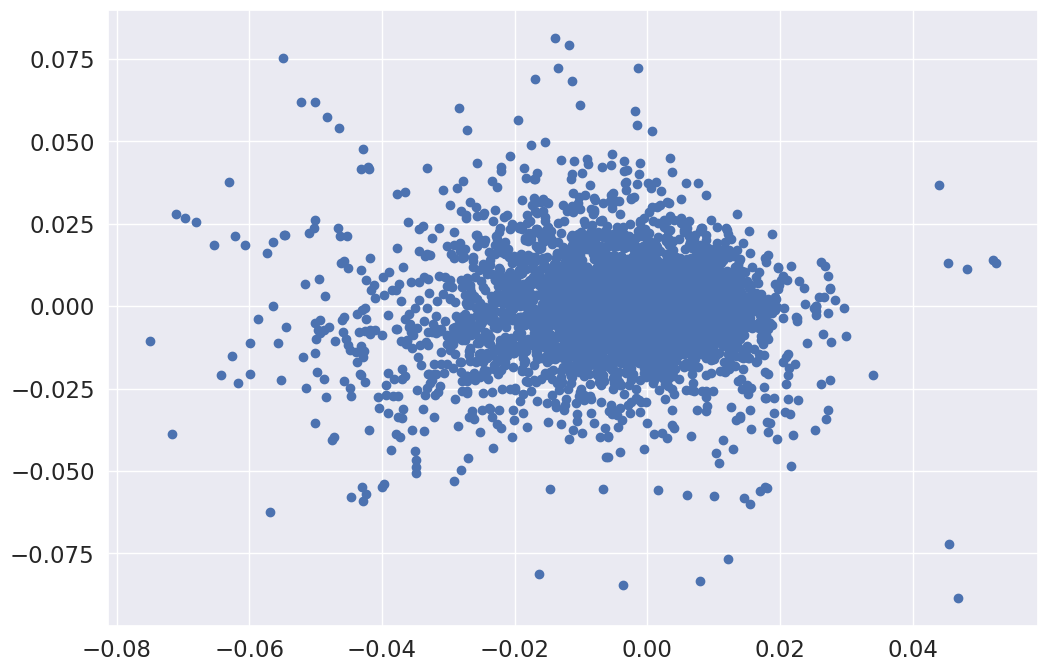

In [18]:
#plt.scatter(pca.components_[0], pca.components_[1], cmap='viridis')
plt.scatter(pca.components_[0], pca.components_[1])
#plt.bar(range(0, pca.n_components_), pca.explained_variance_ratio_)

In [56]:
pca.components_

array([[-5.09624654e-03, -1.64235371e-03, -2.50924283e-03, ...,
        -4.70487229e-05,  6.60722489e-03,  1.77413124e-02],
       [-9.83992950e-04, -3.43556642e-03,  1.58382709e-03, ...,
        -8.74138617e-03, -3.05903135e-03,  9.51295771e-04],
       [-2.11605768e-03, -8.04935018e-03, -4.74634975e-03, ...,
        -4.97406546e-03, -1.08742462e-02, -2.73324120e-02],
       ...,
       [-3.52492711e-03, -2.82178380e-02, -7.55169236e-03, ...,
        -4.77401204e-03,  3.98977478e-03, -4.52006966e-03],
       [ 4.84010054e-04,  1.43855543e-03,  1.45370199e-02, ...,
         1.81322732e-03, -8.89994343e-03, -1.25189261e-02],
       [-2.01157852e-01, -3.43970376e-02, -1.69111707e-01, ...,
         1.79076170e-03,  5.58726741e-03,  1.17932642e-03]])

In [19]:
sns.scatterplot(data = pca.components_, x=pca.components_[0], y=pca.components_[1])

IndexError: arrays used as indices must be of integer (or boolean) type

## 3 - Regroupement hiérarchique

Nous effectuons maintenant le regroupement hiérarchique à l'aide des 4 méthodes de lien vus en cours: Ward, Complete, Average et Single. La distance euclidienne est utilisée comme mesure de dissimilarité. Pour chaque lien, afficher le dendrogramme correspondant (voir `helpers.py`)

**Exercice 3-1 - Linkage par défaut (Ward)**

In [29]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage

In [42]:
nci60 = numericDf
clust_ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(nci60)

In [47]:
df.select_dtypes(include='object')

,Unnamed: 0
0,V1
1,V2
2,V3
3,V4
4,V5
...,...
59,V60
60,V61
61,V62
62,V63


In [43]:
plot_dendogram(clust_ward, orientantion='right', labels=nci60_labels['x'].values, leaf_font_size=10)

NameError: name 'plot_dendogram' is not defined

In [49]:
def draw_dendogram(pDf, pMethod='ward', pOrientation='right'):
    # Calculate pairwise distances between the data points
    distances = pdist(pDf)

    # Use the linkage function to calculate the hierarchical clustering
    linkage_matrix = linkage(distances, method=pMethod)

    # Plot the dendrogram
    dendrogram(linkage_matrix, orientation=pOrientation)
    plt.show()

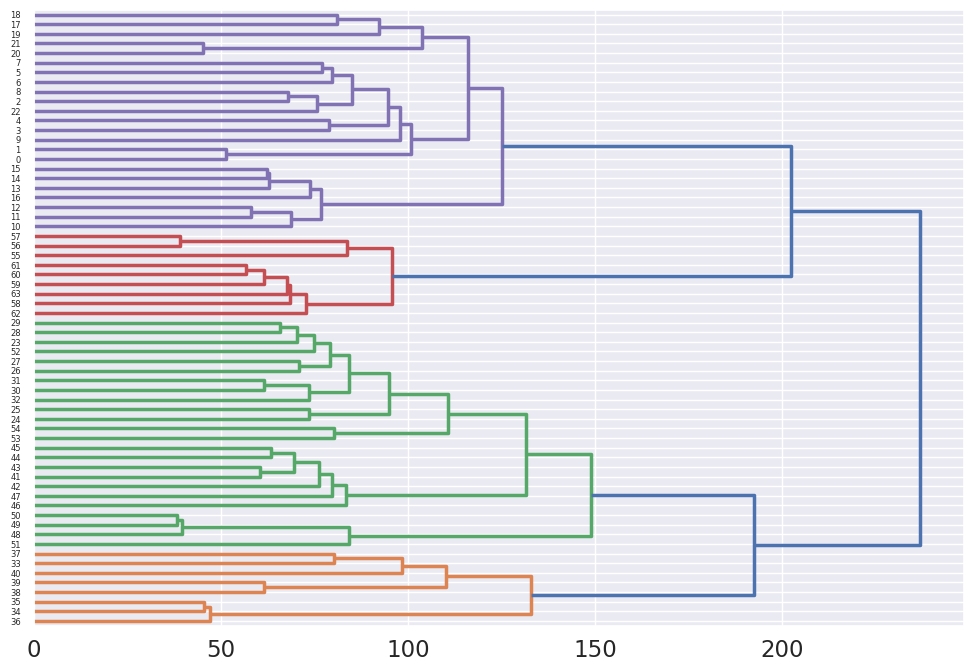

In [50]:
## Ward
draw_dendogram(numericDf, pMethod='ward')

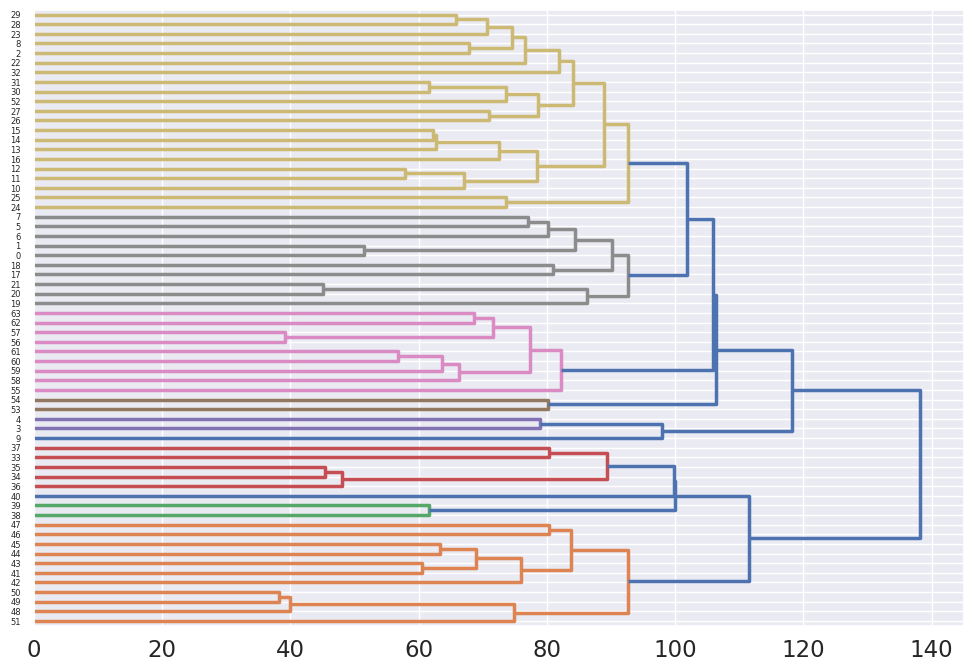

In [51]:
## complete
draw_dendogram(numericDf, pMethod='complete')

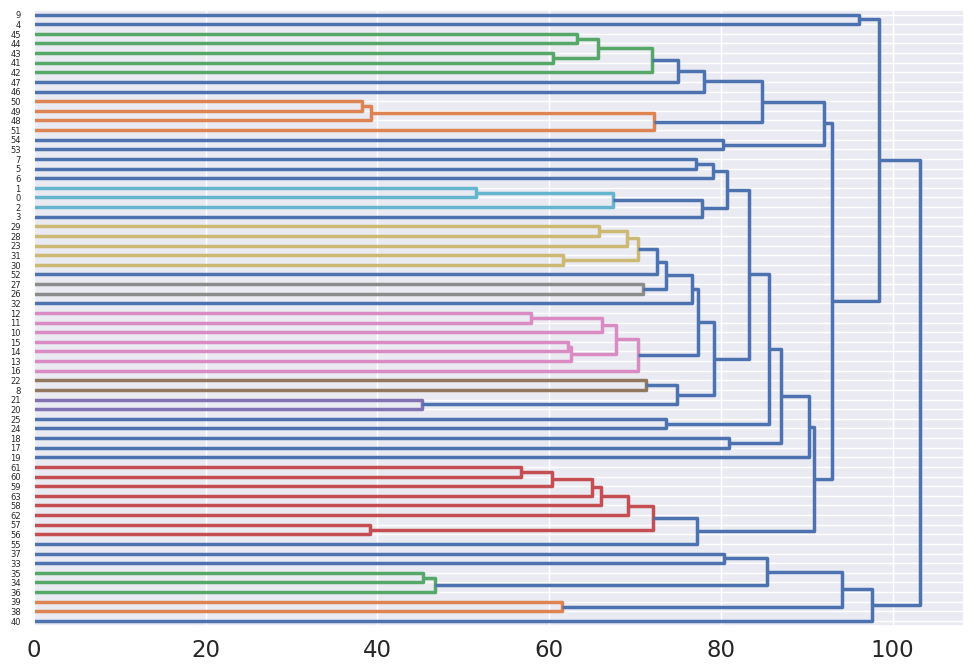

In [52]:
# average
## Ward
draw_dendogram(numericDf, pMethod='average')

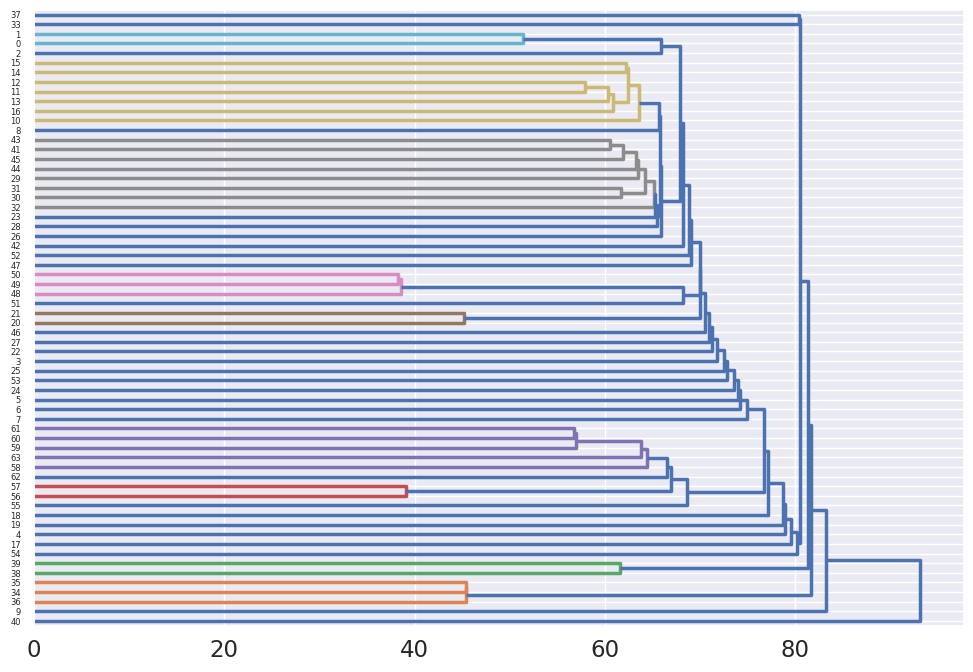

In [53]:
# single
## Ward
draw_dendogram(numericDf, pMethod='single')

### 

Ward est plus exploitable
k = 5

####

In [54]:
clust_complete = AgglomerativeClustering(distance_threshold=None, n_clusters=8).fit(numericDf)

_ = sns.scatterplot(x=numericDf[:, 0], y=numericDf[:, 1], hue = clust_complete.labels_, s=60, palette='Paired')

plt.xlable('PC1')
plt.ylable('PC2')
plt.legend(loc='upper right')

InvalidIndexError: (slice(None, None, None), 0)

In [ ]:
 !!!Ver video aula  2023-03-22 p/ plotagem c/ etiquetas e PCA

In [27]:
# Compléter cette cellule ~ 2 lignes de code
print("Compute unstructured hierarchical clustering...")

ward = AgglomerativeClustering(n_clusters=6, linkage="ward").fit(numericDf)

label = ward.labels_




print(label)
print(f"Number of points: {label.size}")

Compute unstructured hierarchical clustering...


AttributeError: 'AgglomerativeClustering' object has no attribute 'distances_'

In [ ]:
distances = pdist()
#plot_dendrogram()

InvalidIndexError: (array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False]), 0)

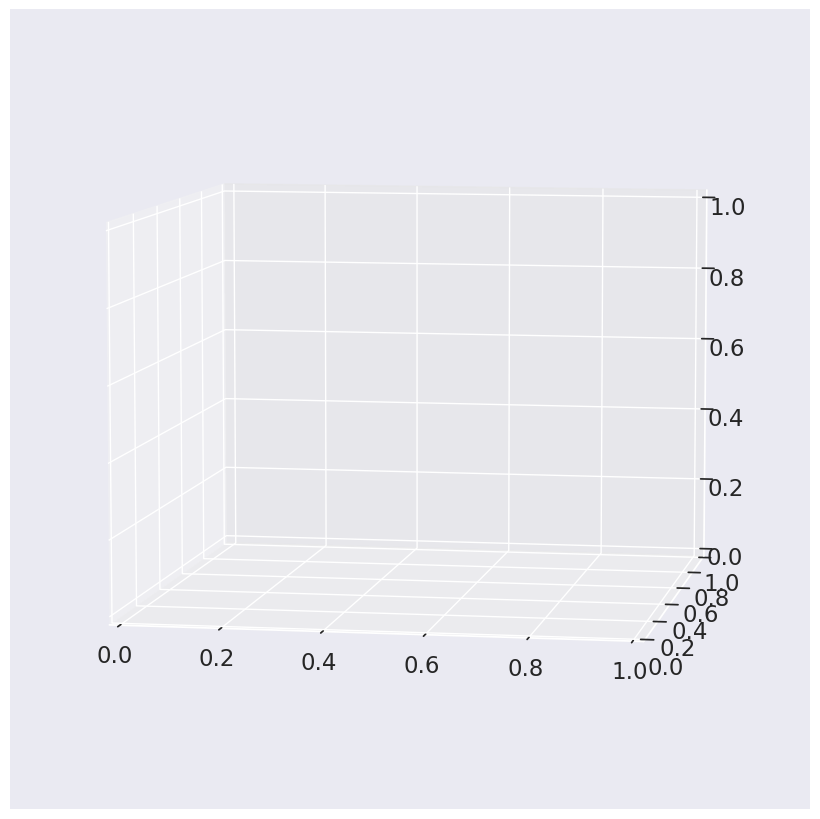

In [42]:
import matplotlib.pyplot as plt
X = numericDf
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d", elev=7, azim=-80)
ax1.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax1.scatter(
        X[label == l, 0],
        X[label == l, 1],
        X[label == l, 2],
        color=plt.cm.jet(float(l) / np.max(label + 1)),
        s=20,
        edgecolor="k",
    )
#_ = fig1.suptitle(f"Without connectivity constraints (time {elapsed_time:.2f}s)")

**Exercice 3-2 - Linkage Complete**

In [ ]:
# Compléter cette cellule ~ 2 lignes de code

**Exercice 3-3 - Linkage average**

In [ ]:
# Compléter cette cellule ~ 2 lignes de code

**Exercice 3-4 - Linkage Single**

In [ ]:
# Compléter cette cellule ~ 2 lignes de code

**Exercice 3-5 - Compte tenu des résultats précédents, choisir une méthode de lien et seuiller le dendrogramme à la hauteur "optimale"**

In [ ]:
# Compléter la cellule ~ 2 lignes de code

## 4 - Partitionnement K-moyennes

**Exercice 4 - Comparer les résultats précédents avec le partitionnement K-moyennes**

In [ ]:
# Compléter la cellule ~ 5-10 lignes de code

## 5 - Débruitage des données par ACP (optionnel)

**Exercice 5 - Effectuer le regroupement hiérarchique directement sur les premières composantes principales. Comparer les résultats obtenus avec ceux du jeu de données "complet"**

In [ ]:
# Compléter la cellule ~ X lignes de code

## 6 - Références

Cet atelier est grandement inspiré du Lab 3: NCI60 Data Example (Introduction to statistical learning)

**Fin de l'atelier 01-03**